# 1.3 SageMaker Training with Experiments and Processing

## 학습 작업의 실행 노트북 개요

- SageMaker Training에 SageMaker 실험을 추가하여 여러 실험의 결과를 비교할 수 있습니다.
    - [작업 실행 시 필요 라이브러리 import](#작업-실행-시-필요-라이브러리-import)
    - [SageMaker 세션과 Role, 사용 버킷 정의](#SageMaker-세션과-Role,-사용-버킷-정의)
    - [하이퍼파라미터 정의](#하이퍼파라미터-정의)
    - [학습 실행 작업 정의](#학습-실행-작업-정의)
        - 학습 코드 명
        - 학습 코드 폴더 명
        - 학습 코드가 사용한 Framework 종류, 버전 등
        - 학습 인스턴스 타입과 개수
        - SageMaker 세션
        - 학습 작업 하이퍼파라미터 정의
        - 학습 작업 산출물 관련 S3 버킷 설정 등
    - [학습 데이터셋 지정](#학습-데이터셋-지정)
        - 학습에 사용하는 데이터셋의 S3 URI 지정
    - [SageMaker 실험 설정](#SageMaker-실험-설정)
    - [학습 실행](#학습-실행)
    - [데이터 세트 설명](#데이터-세트-설명)
    - [실험 결과 보기](#실험-결과-보기)
    - [Evaluation 하기](#Evaluation-하기)

### 작업 실행 시 필요 라이브러리 import

In [7]:
import boto3
import sagemaker

### SageMaker 세션과 Role, 사용 버킷 정의

In [8]:
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

In [9]:
bucket = sagemaker_session.default_bucket()
code_location = f's3://{bucket}/xgboost/code'
output_path = f's3://{bucket}/xgboost/output'

### 하이퍼파라미터 정의

In [10]:
hyperparameters = {
       "scale_pos_weight" : "19",    
        "max_depth": "2",
        "eta": "0.3",
        "objective": "binary:logistic",
        "num_round": "100",
}

### 학습 실행 작업 정의

In [11]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = "local"
max_run = 1*60*60

use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None

In [12]:
if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.session.Session()

In [30]:
from sagemaker.xgboost.estimator import XGBoost

estimator = XGBoost(
    entry_point="xgboost_script.py",
    source_dir="src",
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    role=role,
    sagemaker_session=sagemaker_session,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version="1.7-1",
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


### 학습 데이터셋 지정

In [31]:
data_path=f's3://{bucket}/xgboost/dataset'
!aws s3 sync ../data/dataset/ $data_path

In [32]:
if instance_type in ['local', 'local_gpu']:
    from pathlib import Path
    file_path = f'file://{Path.cwd()}'
    inputs = file_path.split('lab_1_training')[0] + 'data/dataset/'
    
else:
    inputs = data_path
inputs

's3://sagemaker-us-west-2-601760166140/xgboost/dataset'

### SageMaker 실험 설정

In [33]:
# !pip install -U sagemaker-experiments

In [34]:
experiment_name='xgboost-poc-1'

In [35]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from time import strftime

In [36]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [37]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

### 학습 실행

In [38]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

estimator.fit(inputs = {'inputdata': inputs},
                  job_name = job_name,
                  experiment_config={
                      'TrialName': job_name,
                      'TrialComponentDisplayName': job_name,
                  },
                  wait=False)

INFO:sagemaker:Creating training-job with name: xgboost-poc-1-1013-16421728837771


In [45]:
estimator.logs()

2024-10-13 16:43:06 Starting - Preparing the instances for training...
2024-10-13 16:43:32 Downloading - Downloading input data...
2024-10-13 16:44:17 Downloading - Downloading the training image......
2024-10-13 16:45:18 Training - Training image download completed. Training in progress..[2024-10-13 16:45:23.659 ip-10-0-95-88.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-13 16:45:23.684 ip-10-0-95-88.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-13:16:45:24:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-13:16:45:24:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-13:16:45:24:INFO] Invoking user training script.
[2024-10-13:16:45:24:INFO] Module xgboost_script does not provide a setup.py. 
Generating setup.py
[2024-10-13:16:45:24:INFO] Generating setup.cfg
[2024-10-13:16:45:24:INFO] Generating MANIFEST.in
[2024-10-13:16:45:24:INFO] Installing module

###  실험 결과 보기
위의 실험한 결과를 확인 합니다.
- 각각의 훈련잡의 시도에 대한 훈련 사용 데이터, 모델 입력 하이퍼 파라미터, 모델 평가 지표, 모델 아티펙트 결과 위치 등의 확인이 가능합니다.
- **아래의 모든 내용은 SageMaker Studio 를 통해서 직관적으로 확인이 가능합니다.**

In [ ]:
from sagemaker.analytics import ExperimentAnalytics
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100

In [ ]:
trial_component_training_analytics = ExperimentAnalytics(
    sagemaker_session= sagemaker_session,
    experiment_name= experiment_name,
    sort_by="metrics.validation:auc.max",        
    sort_order="Descending",
    metric_names=["validation:auc"]
)

trial_component_training_analytics.dataframe()[['Experiments', 'Trials', 'validation:auc - Min', 'validation:auc - Max',
                                                'validation:auc - Avg', 'validation:auc - StdDev', 'validation:auc - Last', 
                                                'eta', 'max_depth', 'num_round', 'scale_pos_weight']]

,Experiments,Trials,validation:auc - Min,validation:auc - Max,validation:auc - Avg,validation:auc - StdDev,validation:auc - Last,eta,max_depth,num_round,scale_pos_weight
0,[xgboost-poc-1],[xgboost-poc-1-0226-20431708980238],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""
1,[xgboost-poc-1],[xgboost-poc-1-m5-lar-1-xgboost-d-0322-13081647954529],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""
2,[xgboost-poc-1],[xgboost-poc-1-m5-lar-1-xgboost-d-0322-14181647958716],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""
3,[xgboost-poc-1],[Default-Run-Group-xgboost-poc-1],0.821841,0.821841,0.821841,0.0,0.821841,0.2,3.0,100.0,29.0
4,[xgboost-poc-1],[xgboost-poc-1-m5-lar-1-xgboost-d-0605-12551654433745],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""
...,...,...,...,...,...,...,...,...,...,...,...
78,[xgboost-poc-1],[Default-Run-Group-xgboost-poc-1],NaN,NaN,NaN,NaN,NaN,"""0.2""","""3""","""100""","""29"""
79,[xgboost-poc-1],[xgboost-poc-1-m5-lar-1-xgboost-d-0322-14081647958115],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,[xgboost-poc-1],[xgboost-poc-1-t3-med-1-xgboost-d-0322-11521647949951],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,[xgboost-poc-1],[xgboost-poc-1-0213-09081707815334],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Evaluation 하기
SageMaker Processing을 이용하여 Evalution을 수행하는 코드를 동작할 수 있습니다. MLOps에서 Processing을 적용하면 전처리, Evaluation 등을 serverless로 동작할 수 있습니다.

In [46]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [47]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = 'local'

In [48]:
script_eval = FrameworkProcessor(
    XGBoost,
    framework_version="1.7-1",
    role=role,
    instance_type=instance_type,
    instance_count=instance_count
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


In [49]:
artifacts_dir = estimator.model_data

In [44]:
s3_test_path = data_path + '/test.csv'
detect_outputpath = f's3://{bucket}/xgboost/processing'

In [50]:
source_dir='src'

if instance_type == 'local':
    from sagemaker.local import LocalSession
    from pathlib import Path

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    source_dir = f'{Path.cwd()}/src'
    s3_test_path=f'../data/dataset/test.csv'

In [51]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

script_eval.run(
    code="evaluation.py",
    source_dir=source_dir,
    inputs=[ProcessingInput(source=s3_test_path, input_name="test_data", destination="/opt/ml/processing/test"),
            ProcessingInput(source=artifacts_dir, input_name="model_weight", destination="/opt/ml/processing/model")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", output_name='evaluation', destination=detect_outputpath + "/" + job_name),
    ],
    job_name=job_name,
    experiment_config={
        'TrialName': job_name,
        'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:sagemaker.processing:Uploaded src to s3://sagemaker-us-west-2-601760166140/xgboost-poc-1-1013-16471728838039/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-west-2-601760166140/xgboost-poc-1-1013-16471728838039/source/runproc.sh
INFO:sagemaker:Creating processing-job with name xgboost-poc-1-1013-16471728838039


In [52]:
script_eval.latest_job.wait()

..............Requirement already satisfied: xgboost in /miniconda3/lib/python3.8/site-packages (1.7.4)
#############################################
args.model_path: /opt/ml/processing/model/model.tar.gz
args.test_path: /opt/ml/processing/test/test.csv
args.output_evaluation_dir: /opt/ml/processing/output
****** All folder and files under /opt/ml/processing ****** 
('/opt/ml/processing', ['test', 'output', 'model', 'input'], [])
('/opt/ml/processing/test', [], ['test.csv'])
('/opt/ml/processing/output', [], [])
('/opt/ml/processing/model', [], ['model.tar.gz'])
('/opt/ml/processing/input', ['entrypoint', 'code'], [])
('/opt/ml/processing/input/entrypoint', [], ['runproc.sh'])
('/opt/ml/processing/input/code', ['xgboost_script.egg-info', 'build'], ['evaluation.py', 'xgboost_script.py', 'sourcedir.tar.gz'])
('/opt/ml/processing/input/code/xgboost_script.egg-info', [], ['PKG-INFO', 'top_level.txt', 'SOURCES.txt', 'dependency_links.txt'])
('/opt/ml/processing/input/code/build', ['bdist.li

###  실험 결과 확인

In [53]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-west-2-601760166140/xgboost/output/xgboost-poc-1-1013-16421728837771/output/
2024-10-13 16:45:39    2.1 KiB model.tar.gz
2024-10-13 16:45:39  296 Bytes output.tar.gz


In [54]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-us-west-2-601760166140/xgboost/output/xgboost-poc-1-1013-16421728837771/output/model.tar.gz to model/model.tar.gz
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
xgboost-model


In [55]:
!pip install xgboost graphviz

In [59]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

In [60]:
model = xgb.XGBClassifier()
model.load_model("./model/xgboost-model")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

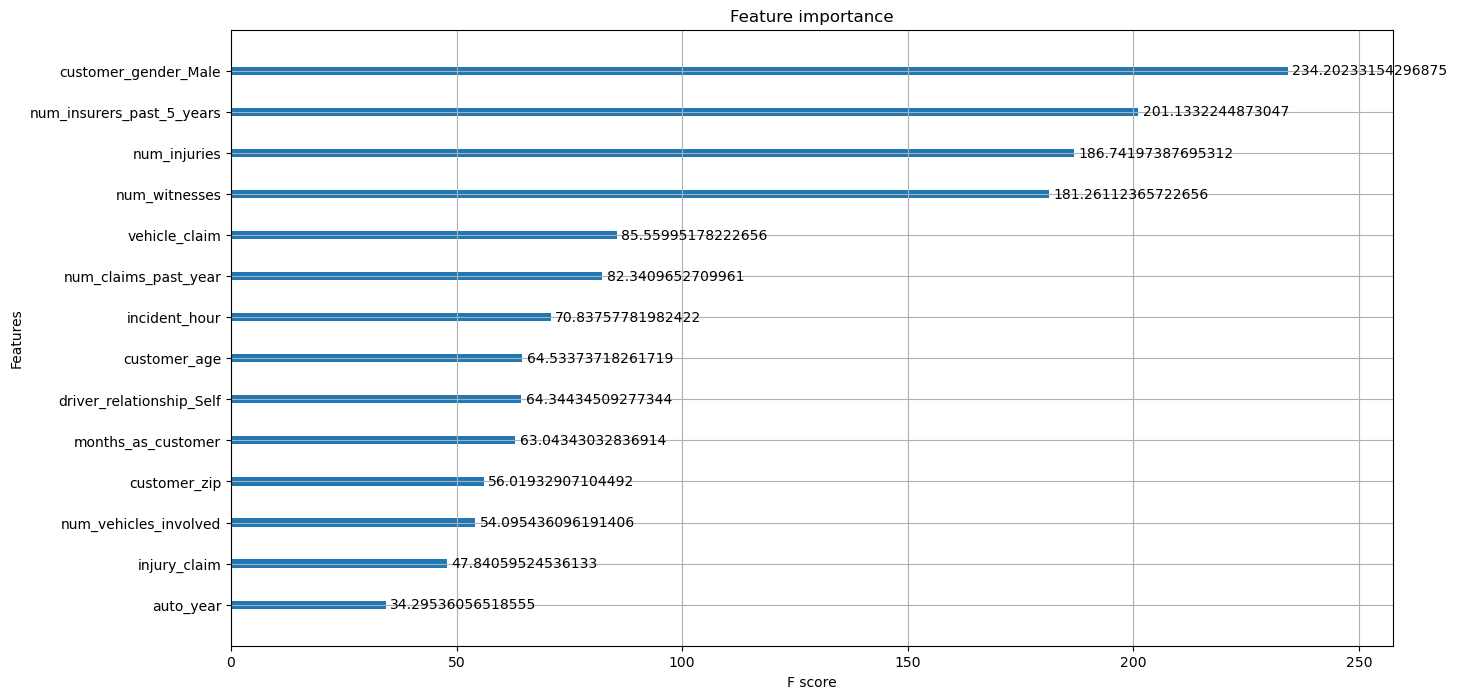

In [61]:
test_prep_df = pd.read_csv('../data/dataset/test.csv')
x_test = test_prep_df.drop('fraud', axis=1)
feature_data = xgb.DMatrix(x_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

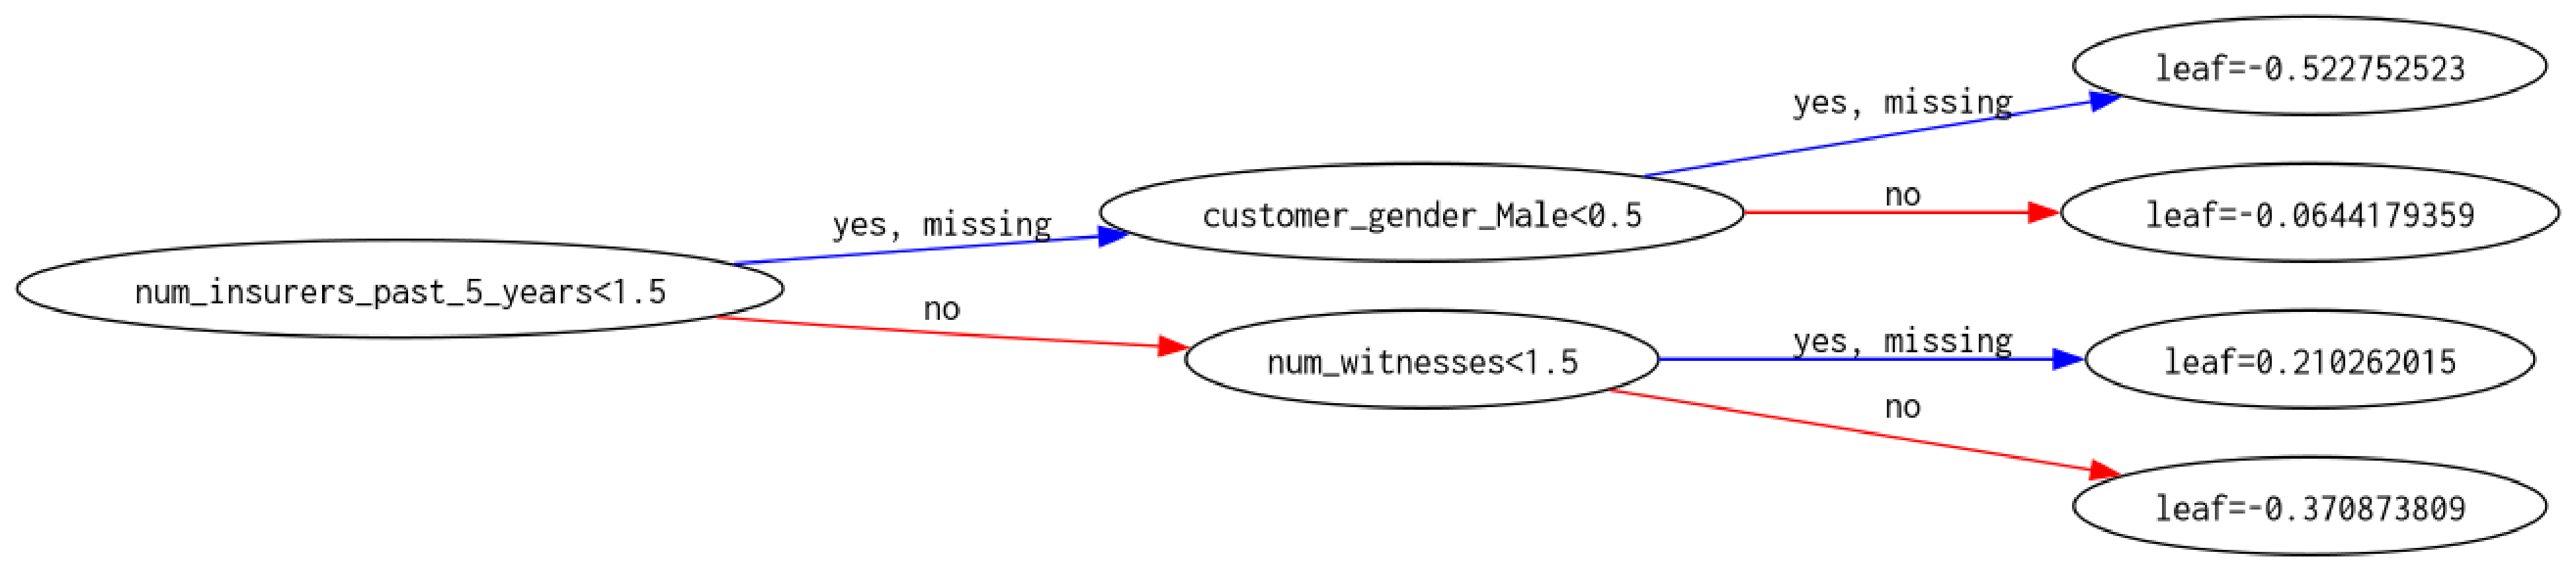

In [62]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(50, 15)
plt.show()